# Decision trees (with original attributes)

In [1]:
import numpy as np
import pandas as pd
import pydotplus
from collections import defaultdict
from sklearn import tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from IPython.display import Image

In [2]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1, join_axes=[dfX.index])
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [3]:
df = pd.read_csv('training_with_working_hours.csv')
df = df.drop(['Unnamed: 0'], 1)
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,WorkingHours
0,23.18,27.272,426.0,721.250000,0.004793,1,1
1,23.15,27.245,426.0,713.500000,0.004779,1,1
2,23.10,27.200,426.0,704.500000,0.004757,1,1
3,23.10,27.200,419.0,701.000000,0.004757,1,1
4,23.10,27.200,419.0,701.666667,0.004757,1,1


In [4]:
class_name = 'Occupancy'
class_labels = df['Occupancy'].values
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res

In [72]:
dt = tree.DecisionTreeClassifier()
f1_for_0 = metrics.make_scorer(metrics.f1_score, pos_label = 0)
f1_for_1 = metrics.make_scorer(metrics.f1_score, pos_label = 1)

parameters = {'criterion': ['gini', 'entropy'], 
              'max_depth': np.arange(1,11),
              'min_samples_leaf': np.arange(1,100,5),
              'min_samples_split': np.arange(2,200,5)}
clf_1 = GridSearchCV (estimator = dt, param_grid = parameters, scoring = {'f1_for_class_1': f1_for_1, 'f1_for_class_0': f1_for_0}, cv = 5, refit = 'f1_for_class_1')

In [73]:
clf_1.fit(df.drop('Occupancy', 1), class_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n...
                         'min_samples_split': array([  2,   7,  12,  17,  22,  27,  32,  37,  42,  47,  52,  57,  62,
        67,  72,  77,  82,

In [74]:
results = pd.DataFrame(clf_1.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_f1_for_class_1,...,std_test_f1_for_class_1,rank_test_f1_for_class_1,split0_test_f1_for_class_0,split1_test_f1_for_class_0,split2_test_f1_for_class_0,split3_test_f1_for_class_0,split4_test_f1_for_class_0,mean_test_f1_for_class_0,std_test_f1_for_class_0,rank_test_f1_for_class_0
0,0.007849,0.002737,0.004766,0.000124,gini,1,1,2,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.944444,...,0.017543,7359,0.98455,0.998687,0.993946,0.995513,0.996839,0.993906,0.004932,7372
1,0.006336,0.000183,0.004642,0.000025,gini,1,1,7,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.944444,...,0.017543,7359,0.98455,0.998687,0.993946,0.995513,0.996839,0.993906,0.004932,7372
2,0.007886,0.002423,0.005859,0.001485,gini,1,1,12,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.944444,...,0.017543,7359,0.98455,0.998687,0.993946,0.995513,0.996839,0.993906,0.004932,7372
3,0.007844,0.001407,0.005562,0.000730,gini,1,1,17,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.944444,...,0.017543,7359,0.98455,0.998687,0.993946,0.995513,0.996839,0.993906,0.004932,7372
4,0.008917,0.000888,0.005979,0.000684,gini,1,1,22,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.944444,...,0.017543,7359,0.98455,0.998687,0.993946,0.995513,0.996839,0.993906,0.004932,7372
5,0.006982,0.001081,0.005234,0.001501,gini,1,1,27,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.944444,...,0.017543,7359,0.98455,0.998687,0.993946,0.995513,0.996839,0.993906,0.004932,7372
6,0.007912,0.001598,0.005303,0.001100,gini,1,1,32,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.944444,...,0.017543,7359,0.98455,0.998687,0.993946,0.995513,0.996839,0.993906,0.004932,7372
7,0.007408,0.000969,0.005769,0.001491,gini,1,1,37,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.944444,...,0.017543,7359,0.98455,0.998687,0.993946,0.995513,0.996839,0.993906,0.004932,7372
8,0.006337,0.000648,0.004536,0.001126,gini,1,1,42,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.944444,...,0.017543,7359,0.98455,0.998687,0.993946,0.995513,0.996839,0.993906,0.004932,7372
9,0.006045,0.000148,0.004425,0.000316,gini,1,1,47,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.944444,...,0.017543,7359,0.98455,0.998687,0.993946,0.995513,0.996839,0.993906,0.004932,7372


In [75]:
print('Best parameters:')
results.loc[1600]

Best parameters:


mean_fit_time                                                         0.0144713
std_fit_time                                                        0.000292441
mean_score_time                                                      0.00585074
std_score_time                                                       0.00103472
param_criterion                                                            gini
param_max_depth                                                               3
param_min_samples_leaf                                                        1
param_min_samples_split                                                       2
params                        {'criterion': 'gini', 'max_depth': 3, 'min_sam...
split0_test_f1_for_class_1                                             0.944444
split1_test_f1_for_class_1                                             0.988945
split2_test_f1_for_class_1                                             0.970297
split3_test_f1_for_class_1              

In [76]:
dt_best = clf_1.best_estimator_

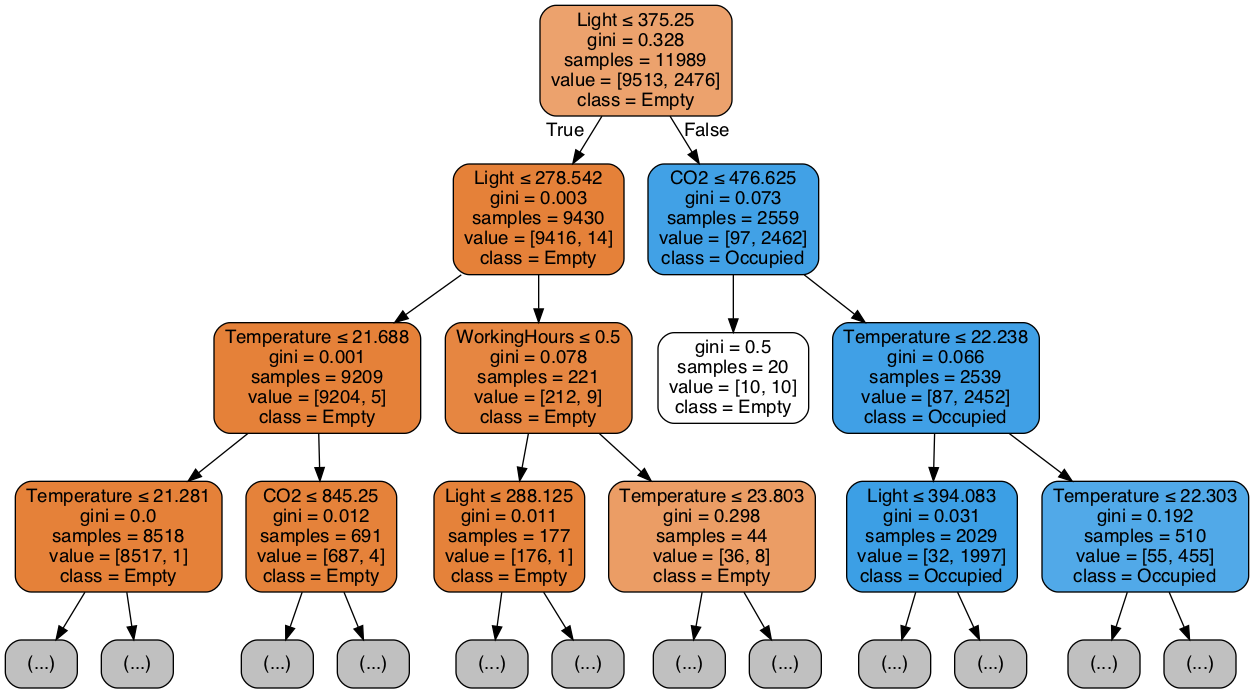

In [77]:
class_labels = df['Occupancy'].values
dt_best.fit(df.drop('Occupancy', 1), class_labels)

dot_data = tree.export_graphviz(dt_best, out_file=None,
                                feature_names=df.drop('Occupancy', 1).columns,
                                class_names=['Occupied' if x == 1 else 'Empty' for x in dt_best.classes_],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [79]:
for col, imp in zip(df.drop('Occupancy', 1).columns, dt_best.feature_importances_):
    print(col, imp)

Temperature 0.005110081737973688
Humidity 0.0
Light 0.9919961015829986
CO2 0.0023100957733909844
HumidityRatio 0.0
WorkingHours 0.0005837209056367069


## Using the best dt to predict the test class

In [5]:
df_test = pd.read_csv('test_with_working_hours.csv')

In [6]:
df_test = df_test.drop('Unnamed: 0', 1)
df_test.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,WorkingHours
0,23.15,27.267500,429.5,714.000000,0.004783,1,1
1,23.15,27.200000,426.0,708.250000,0.004772,1,1
2,23.10,27.200000,419.0,689.333333,0.004757,1,1
3,23.10,27.166667,419.0,683.500000,0.004751,1,0
4,23.05,27.150000,419.0,687.500000,0.004734,1,0


In [7]:
res = prepare_dataset(df_test, class_name)
df_test, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res

In [8]:
# just verifying the effect of Guidotti's 'prepare_dataset' function
df_test.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,WorkingHours,Occupancy
0,23.15,27.267500,429.5,714.000000,0.004783,1,1
1,23.15,27.200000,426.0,708.250000,0.004772,1,1
2,23.10,27.200000,419.0,689.333333,0.004757,1,1
3,23.10,27.166667,419.0,683.500000,0.004751,0,1
4,23.05,27.150000,419.0,687.500000,0.004734,0,1


In [84]:
# actual prediction:
y_pred_tr = dt_best.predict(df.drop('Occupancy',1))
y_pred_test = dt_best.predict(df_test.drop('Occupancy',1))

### Analyzing the classification performance

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [86]:
print('Train Accuracy %s' % accuracy_score(df['Occupancy'].values, y_pred_tr))
print('Train F1-score %s' % f1_score(df['Occupancy'].values, y_pred_tr, average=None))
print()

print('Test Accuracy %s' % accuracy_score(df_test['Occupancy'].values, y_pred_test))
print('Test F1-score %s' % f1_score(df_test['Occupancy'].values, y_pred_test, average=None))
print(classification_report(df_test['Occupancy'].values, y_pred_test))
confusion_matrix(df_test['Occupancy'].values, y_pred_test)

Train Accuracy 0.9907415130536324
Train F1-score [0.9941465 0.9778664]

Test Accuracy 0.9913647138503217
Test F1-score [0.99444384 0.98063046]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4604
           1       0.97      0.99      0.98      1302

    accuracy                           0.99      5906
   macro avg       0.98      0.99      0.99      5906
weighted avg       0.99      0.99      0.99      5906



array([[4564,   40],
       [  11, 1291]])

## Trying out different k's (for cross-validation)

### k = 3

In [10]:
dt = tree.DecisionTreeClassifier()
f1_for_0 = metrics.make_scorer(metrics.f1_score, pos_label = 0)
f1_for_1 = metrics.make_scorer(metrics.f1_score, pos_label = 1)

parameters = {'criterion': ['gini', 'entropy'], 
              'max_depth': np.arange(1,11),
              'min_samples_leaf': np.arange(1,100,5),
              'min_samples_split': np.arange(2,200,5)}
clf_2 = GridSearchCV (estimator = dt, param_grid = parameters, scoring = {'f1_for_class_1': f1_for_1, 'f1_for_class_0': f1_for_0}, cv = 3, refit = 'f1_for_class_1')

In [11]:
clf_2.fit(df.drop('Occupancy', 1), class_labels)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n...
                         'min_samples_split': array([  2,   7,  12,  17,  22,  27,  32,  37,  42,  47,  52,  57,  62,
        67,  72,  77,  82,

In [12]:
results = pd.DataFrame(clf_2.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_f1_for_class_1,...,split2_test_f1_for_class_1,mean_test_f1_for_class_1,std_test_f1_for_class_1,rank_test_f1_for_class_1,split0_test_f1_for_class_0,split1_test_f1_for_class_0,split2_test_f1_for_class_0,mean_test_f1_for_class_0,std_test_f1_for_class_0,rank_test_f1_for_class_0
0,0.008193,0.003320,0.005192,0.000155,gini,1,1,2,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.964139,...,0.987981,0.977244,0.009877,1,0.990307,0.994624,0.996839,0.993923,0.002713,1
1,0.005929,0.000360,0.006042,0.001065,gini,1,1,7,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.964139,...,0.987981,0.977244,0.009877,1,0.990307,0.994624,0.996839,0.993923,0.002713,1
2,0.005562,0.000095,0.005028,0.000138,gini,1,1,12,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.964139,...,0.987981,0.977244,0.009877,1,0.990307,0.994624,0.996839,0.993923,0.002713,1
3,0.006629,0.001621,0.005518,0.000519,gini,1,1,17,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.964139,...,0.987981,0.977244,0.009877,1,0.990307,0.994624,0.996839,0.993923,0.002713,1
4,0.005623,0.000376,0.005147,0.000101,gini,1,1,22,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.964139,...,0.987981,0.977244,0.009877,1,0.990307,0.994624,0.996839,0.993923,0.002713,1
5,0.005755,0.000433,0.005438,0.000334,gini,1,1,27,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.964139,...,0.987981,0.977244,0.009877,1,0.990307,0.994624,0.996839,0.993923,0.002713,1
6,0.005834,0.000278,0.006059,0.001129,gini,1,1,32,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.964139,...,0.987981,0.977244,0.009877,1,0.990307,0.994624,0.996839,0.993923,0.002713,1
7,0.005912,0.000209,0.005568,0.000474,gini,1,1,37,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.964139,...,0.987981,0.977244,0.009877,1,0.990307,0.994624,0.996839,0.993923,0.002713,1
8,0.005870,0.000664,0.006385,0.001376,gini,1,1,42,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.964139,...,0.987981,0.977244,0.009877,1,0.990307,0.994624,0.996839,0.993923,0.002713,1
9,0.005684,0.000215,0.005529,0.000607,gini,1,1,47,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.964139,...,0.987981,0.977244,0.009877,1,0.990307,0.994624,0.996839,0.993923,0.002713,1


In [13]:
dt_best_2 = clf_2.best_estimator_
dt_best_2

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

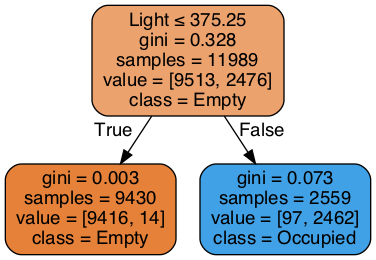

In [14]:
tree_2_data = tree.export_graphviz(dt_best_2, out_file=None,
                                feature_names=df.drop('Occupancy', 1).columns,
                                class_names=['Occupied' if x == 1 else 'Empty' for x in dt_best_2.classes_],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=4)  
tree_2_graph = pydotplus.graph_from_dot_data(tree_2_data)  
Image(tree_2_graph.create_png())

In [15]:
for col, imp in zip(df.drop('Occupancy', 1).columns, dt_best_2.feature_importances_):
    print(col, imp)

Temperature 0.0
Humidity 0.0
Light 1.0
CO2 0.0
HumidityRatio 0.0
WorkingHours 0.0


In [16]:
# actual prediction:
y_pred_tr = dt_best_2.predict(df.drop('Occupancy',1))
y_pred_test = dt_best_2.predict(df_test.drop('Occupancy',1))

In [17]:
print('Train Accuracy %s' % accuracy_score(df['Occupancy'].values, y_pred_tr))
print('Train F1-score %s' % f1_score(df['Occupancy'].values, y_pred_tr, average=None))
print()

print('Test Accuracy %s' % accuracy_score(df_test['Occupancy'].values, y_pred_test))
print('Test F1-score %s' % f1_score(df_test['Occupancy'].values, y_pred_test, average=None))
print(classification_report(df_test['Occupancy'].values, y_pred_test))
confusion_matrix(df_test['Occupancy'].values, y_pred_test)

Train Accuracy 0.9907415130536324
Train F1-score [0.99414032 0.97795432]

Test Accuracy 0.9910260751777853
Test F1-score [0.99422091 0.97993184]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4604
           1       0.97      0.99      0.98      1302

    accuracy                           0.99      5906
   macro avg       0.98      0.99      0.99      5906
weighted avg       0.99      0.99      0.99      5906



array([[4559,   45],
       [   8, 1294]])

### k= 10

In [12]:
dt = tree.DecisionTreeClassifier()

f1_for_0 = metrics.make_scorer(metrics.f1_score, pos_label = 0)
f1_for_1 = metrics.make_scorer(metrics.f1_score, pos_label = 1)


parameters = {'criterion': ['gini', 'entropy'], 
              'max_depth': np.arange(1,11),
              'min_samples_leaf': np.arange(1,100,5),
              'min_samples_split': np.arange(2,200,5)}

clf_3 = GridSearchCV (estimator = dt, param_grid = parameters, scoring = {'f1_for_class_1': f1_for_1, 'f1_for_class_0': f1_for_0}, cv = 10, refit = 'f1_for_class_1')

In [13]:
clf_3.fit(df.drop('Occupancy', 1), class_labels)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn',...
                         'min_samples_split': array([  2,   7,  12,  17,  22,  27,  32,  37,  42,  47,  52,  57,  62,
        67,  72,  77,  82, 

In [14]:
results = pd.DataFrame(clf_3.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_f1_for_class_1,...,split3_test_f1_for_class_0,split4_test_f1_for_class_0,split5_test_f1_for_class_0,split6_test_f1_for_class_0,split7_test_f1_for_class_0,split8_test_f1_for_class_0,split9_test_f1_for_class_0,mean_test_f1_for_class_0,std_test_f1_for_class_0,rank_test_f1_for_class_0
0,0.007666,0.003412,0.003981,0.001174,gini,1,1,2,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.914498,...,0.998947,0.997895,0.989984,0.994715,0.99631,0.996835,0.996842,0.993994,0.006768,394
1,0.006350,0.000067,0.003588,0.000058,gini,1,1,7,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.914498,...,0.998947,0.997895,0.989984,0.994715,0.99631,0.996835,0.996842,0.993994,0.006768,394
2,0.006593,0.000267,0.003636,0.000135,gini,1,1,12,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.914498,...,0.998947,0.997895,0.989984,0.994715,0.99631,0.996835,0.996842,0.993994,0.006768,394
3,0.006393,0.000054,0.003601,0.000079,gini,1,1,17,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.914498,...,0.998947,0.997895,0.989984,0.994715,0.99631,0.996835,0.996842,0.993994,0.006768,394
4,0.006635,0.000487,0.003851,0.000409,gini,1,1,22,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.914498,...,0.998947,0.997895,0.989984,0.994715,0.99631,0.996835,0.996842,0.993994,0.006768,394
5,0.006750,0.001030,0.003687,0.000428,gini,1,1,27,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.914498,...,0.998947,0.997895,0.989984,0.994715,0.99631,0.996835,0.996842,0.993994,0.006768,394
6,0.007180,0.001194,0.004829,0.001500,gini,1,1,32,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.914498,...,0.998947,0.997895,0.989984,0.994715,0.99631,0.996835,0.996842,0.993994,0.006768,394
7,0.009533,0.000637,0.006793,0.001015,gini,1,1,37,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.914498,...,0.998947,0.997895,0.989984,0.994715,0.99631,0.996835,0.996842,0.993994,0.006768,394
8,0.007435,0.001060,0.004668,0.001158,gini,1,1,42,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.914498,...,0.998947,0.997895,0.989984,0.994715,0.99631,0.996835,0.996842,0.993994,0.006768,394
9,0.006878,0.000815,0.004136,0.001024,gini,1,1,47,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.914498,...,0.998947,0.997895,0.989984,0.994715,0.99631,0.996835,0.996842,0.993994,0.006768,394


In [26]:
dt_best_3 = clf_3.best_estimator_
dt_best_3

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=26, min_samples_split=67,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

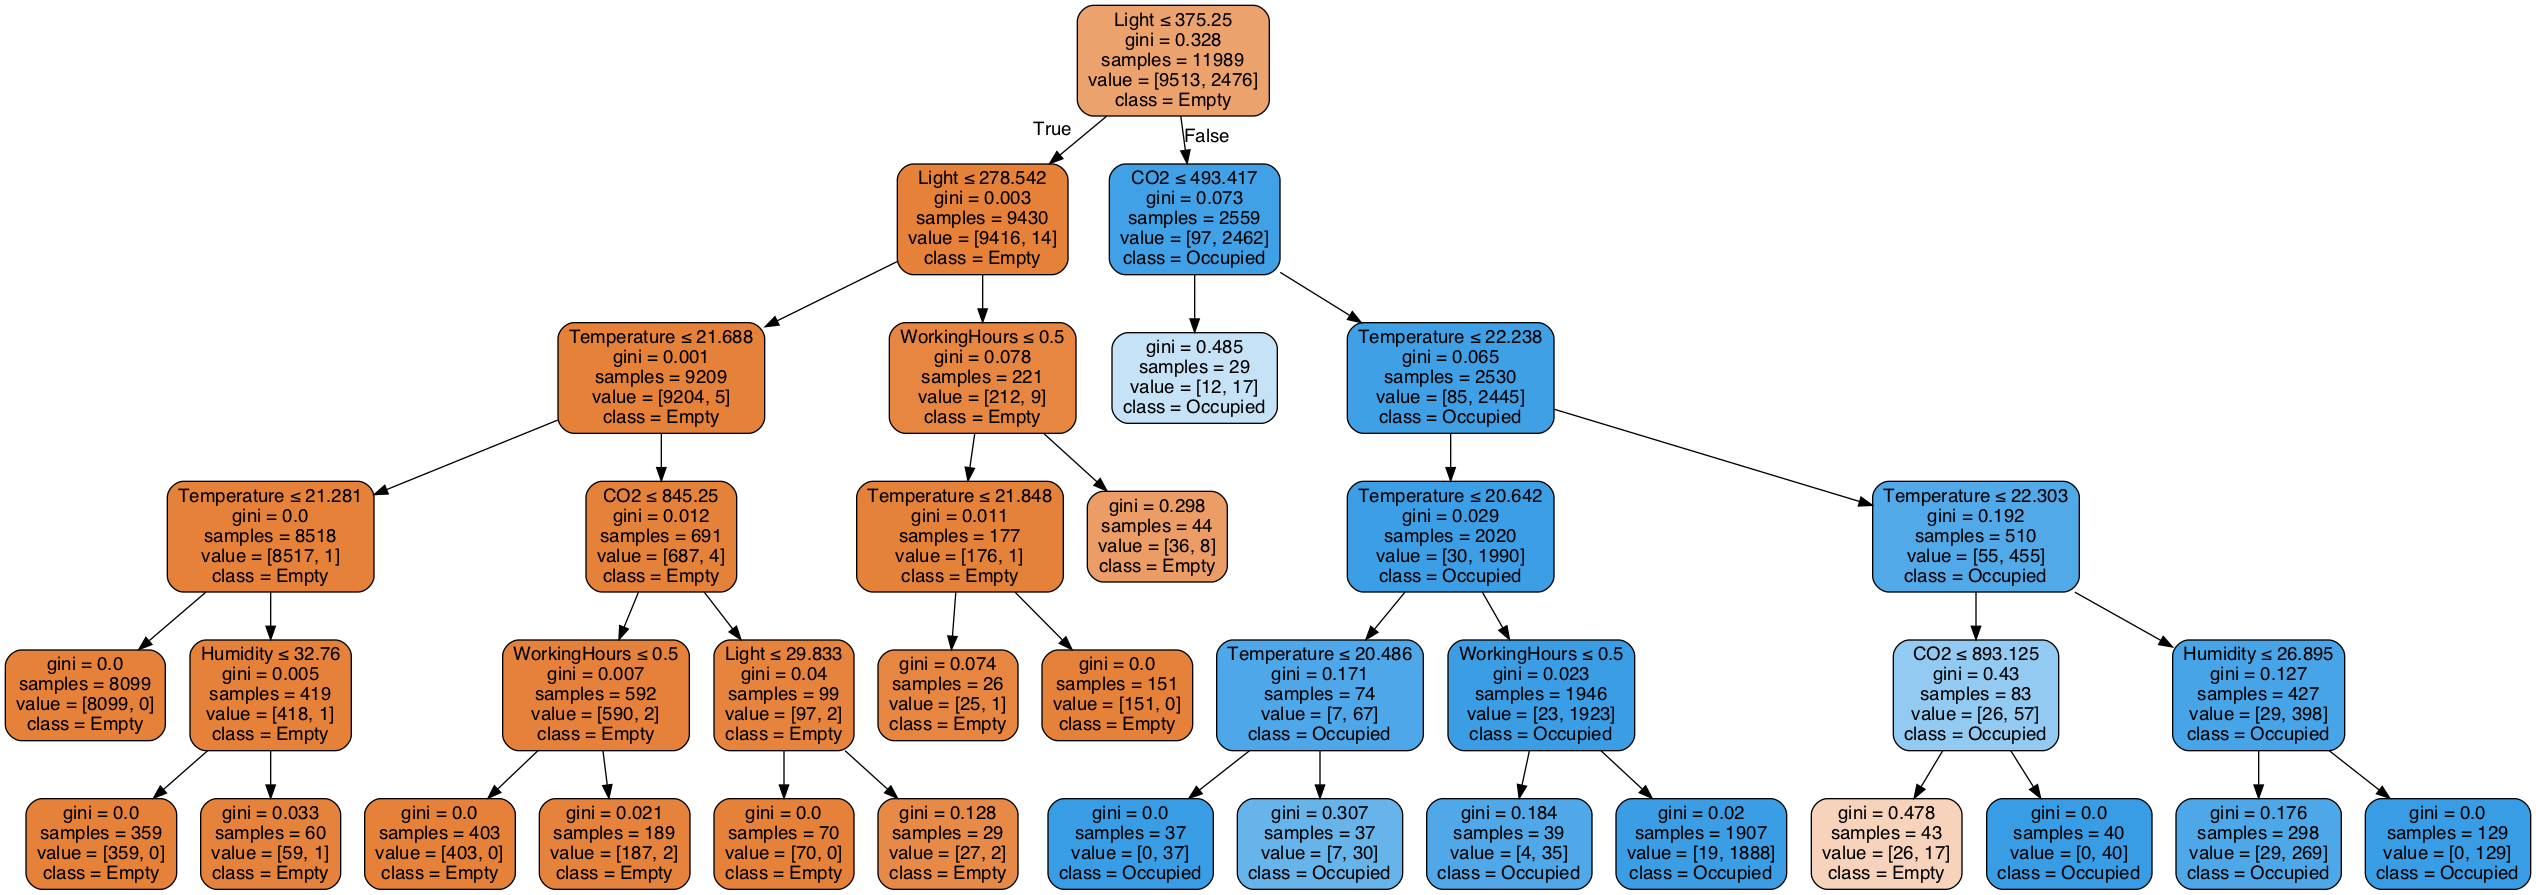

In [17]:
tree_3_data = tree.export_graphviz(dt_best_3, out_file=None,
                                feature_names=df.drop('Occupancy', 1).columns,
                                class_names=['Occupied' if x == 1 else 'Empty' for x in dt_best_3.classes_],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=5)  
tree_3_graph = pydotplus.graph_from_dot_data(tree_3_data)  
Image(tree_3_graph.create_png())

In [18]:
for col, imp in zip(df.drop('Occupancy', 1).columns, dt_best_3.feature_importances_):
    print(col, imp)

Temperature 0.004737577622877442
Humidity 0.00046091830681716287
Light 0.9877933546010697
CO2 0.0062447279565370235
HumidityRatio 0.0
WorkingHours 0.0007634215126987947


In [19]:
# actual prediction:
y_pred_tr = dt_best_3.predict(df.drop('Occupancy',1))
y_pred_test = dt_best_3.predict(df_test.drop('Occupancy',1))

In [20]:
print('Train Accuracy %s' % accuracy_score(df['Occupancy'].values, y_pred_tr))
print('Train F1-score %s' % f1_score(df['Occupancy'].values, y_pred_tr, average=None))
print()

print('Test Accuracy %s' % accuracy_score(df_test['Occupancy'].values, y_pred_test))
print('Test F1-score %s' % f1_score(df_test['Occupancy'].values, y_pred_test, average=None))
print(classification_report(df_test['Occupancy'].values, y_pred_test))
confusion_matrix(df_test['Occupancy'].values, y_pred_test)

Train Accuracy 0.991492201184419
Train F1-score [0.99462762 0.97956731]

Test Accuracy 0.9905181171689807
Test F1-score [0.99390509 0.97865854]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4604
           1       0.97      0.99      0.98      1302

    accuracy                           0.99      5906
   macro avg       0.98      0.99      0.99      5906
weighted avg       0.99      0.99      0.99      5906



array([[4566,   38],
       [  18, 1284]])

### k= 20

In [27]:
dt = tree.DecisionTreeClassifier()

f1_for_0 = metrics.make_scorer(metrics.f1_score, pos_label = 0)
f1_for_1 = metrics.make_scorer(metrics.f1_score, pos_label = 1)


parameters = {'criterion': ['gini', 'entropy'], 
              'max_depth': np.arange(1,11),
              'min_samples_leaf': np.arange(1,100,5),
              'min_samples_split': np.arange(2,200,5)}

clf_4 = GridSearchCV (estimator = dt, param_grid = parameters, scoring = {'f1_for_class_1': f1_for_1, 'f1_for_class_0': f1_for_0}, cv = 20, refit = 'f1_for_class_1')

Ho effettivamente fatto la cross validation con k=20, ma c'è stato qualche problema nel salvataggio del Notebook e non mi ha fatto salvare le caselle. Comunque ho fatto gli screenshot, il risultato era un albero a un solo livello che usava solamente Light con gli stessi risultati di k=10 (carico anche lo screenshot, comunque).